In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
import re
data = pd.read_csv('techscene.csv')

# Data cleaning

In order to make cleaning and analysis easier, we replace all uppercase letters in the data with lowercase. We also remove some instances of superfluous information from job titles, such as strings like "(m/f/d)" or "SEB | Tallinn".

In [2]:
for column in data.columns:#teeme kõik väiketähtedeks
  data[column]=data[column].str.lower()
#job_name
#remove (m/f/d),(m/f/x),| SEB, Tallinn,
data['job_name']=data['job_name'].str.replace('(m/f/d)', '').replace('(m/f/x)','').replace('| SEB, Tallinn','').replace('\"','')

Some of the data from the beginning of the scraping period doesn't include the field `domain`; the value of this field for these listings is `nan`. We can retroactively add these based on the title of the listing.

In [9]:
data[data['domain'].isnan()].shape

AttributeError: 'Series' object has no attribute 'isnan'

In [3]:
data['domain'].unique()

array([nan, 'analytics', 'front-end', 'back-end', 'full-stack', 'mobile',
       'software-development', 'other', 'devops-sre', 'data-science',
       'cyber-security', 'ai-ml', 'qa', 'sales', 'finance', 'marketing',
       'design', 'hr', 'customer-support', 'management'], dtype=object)

In [4]:
replacement_dict={#regex: domain,
  'software engineer|tarkvaraarendaja': 'software-development',
  'front-end|frontend|react': 'front-end',
  'back-end|backend': 'back-end',
  'android|ios': 'mobile',
  'devops': 'devops-sre',
  'data scientist': 'data-science'
  }
for index, row in data[data['domain'].isna()].iterrows():#iterate through all listings that have the 'domain' column as 'nan'
  matched=False
  for regex in replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a domain from replacement_dict
      matched=True
      data.loc[index,'domain']=replacement_dict[regex]
      print(row['job_name']+': changed domain to '+replacement_dict[regex])#debugging
  if not matched:#debugging
    print(row['job_name']+' not matched')

front-end software engineer: changed domain to software-development
react native developer: changed domain to front-end
front-end developer: changed domain to front-end
front-end-vanemarendaja: changed domain to front-end
front-end developer: changed domain to front-end
senior react native engineer: changed domain to front-end
full-stack developer (php, vue.js) not matched
front-end developer for internetbank platform team | seb, tallinn: changed domain to front-end
lead full-stack react developer: changed domain to front-end
react front-end developer (mid/senior): changed domain to front-end
react native developer: changed domain to front-end
senior frontend developer: changed domain to front-end
front-end developer for hub88: changed domain to front-end
gaming - frontend software engineer: changed domain to software-development
senior backend developer (.net): changed domain to back-end
gaming - backend .net software engineer: changed domain to software-development
engagement - senio

In [12]:
data[data['domain'].isnan()].shape

AttributeError: 'Series' object has no attribute 'isnan'

In [ ]:
"""
Groups data by company name, job name, and job link. 
Sorts the data by date added and creates blocks of consecutive job postings.
"""

def process_job_data(data):
    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Normalize text for comparison
    data['job_name'] = data['job_name'].str.lower()
    data['company_name'] = data['company_name'].str.lower()

    # Remove exact duplicates
    data = data.drop_duplicates()

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])

    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    for (company_name, job_name, job_link), group in grouped:
        group = group.sort_values('date_added')

        start_date = None
        prev_date = None

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        for current_date in group['date_added']:
            if start_date is None:
                start_date = current_date
                prev_date = current_date
            elif (current_date - prev_date).days > 1:
                # Special case: check only for 2024-09-06
                if (prev_date == pd.to_datetime('2024-09-05').date() and 
                    current_date == pd.to_datetime('2024-09-07').date()):
                    prev_date = current_date  # Assume continuity
                else:
                    # Save current block if gap is not special case
                    new_data = pd.concat([new_data, pd.DataFrame({
                        "company_name": [company_name],
                        "job_name": [job_name],
                        "domain": [domain],
                        "first_appeared": [start_date],
                        "last_appeared": [prev_date],
                        "job_link": [job_link]
                    })], ignore_index=True)
                    start_date = current_date

                start_date = current_date  # Start a new block

            prev_date = current_date

        # Save the last block
        new_data = pd.concat([new_data, pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [start_date],
            "last_appeared": [prev_date],
            "job_link": [job_link]
        })], ignore_index=True)

    return new_data

# Example usage:
# data = pd.read_csv('input.csv')
#nd = data.copy()
#new_data = process_job_data(nd)
#processed_data.to_csv('new_data2.csv', index=False)


In [14]:
"""
Groups data by company name, job name, and job link.
Finds the first apperance and last apperance dates.
"""

def process_job_data(data):
    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])
    
    # Group by unique identifying columns
    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    # Iterate through each unique group
    for (company_name, job_name, job_link), group in grouped:
        # Find the first and last appearance dates
        first_appeared = group['date_added'].min()
        last_appeared = group['date_added'].max()
        

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        # Create a new row for this unique entry
        new_row = pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [first_appeared],
            "last_appeared": [last_appeared],
            "job_link": [job_link]
        })
        
        # Append to new_data
        new_data = pd.concat([new_data, new_row], ignore_index=True)
    
    return new_data

# Example usage
# data = pd.read_csv('your_input_file.csv')  # Load your input data
nd = data.copy()
new_data = process_job_data(nd)
#new_data.to_csv('new_data!!!!!!!.csv', index=False)  # Save processed data

In [6]:
"""
Checks if first data has the same links as second data.
"""
def chek_links(data, data2):

    links1 = data["job_link"].unique()
    links2 = data2["job_link"].unique()
    for link in links1:
        if link not in links2:
            print(link)
chek_links(data, new_data)

# Analyzing listings by time

## Plot total amount of listings by time

## Identify listings that have been up for a long time
Sort by length, report results, are there any other common traits between these listings?


## Identify listings that get posted repeatedly
Kasutame decision treed, et ennustada kuulutuse kordumist

# What domains are the most popular?

Sort by domain, report frequency

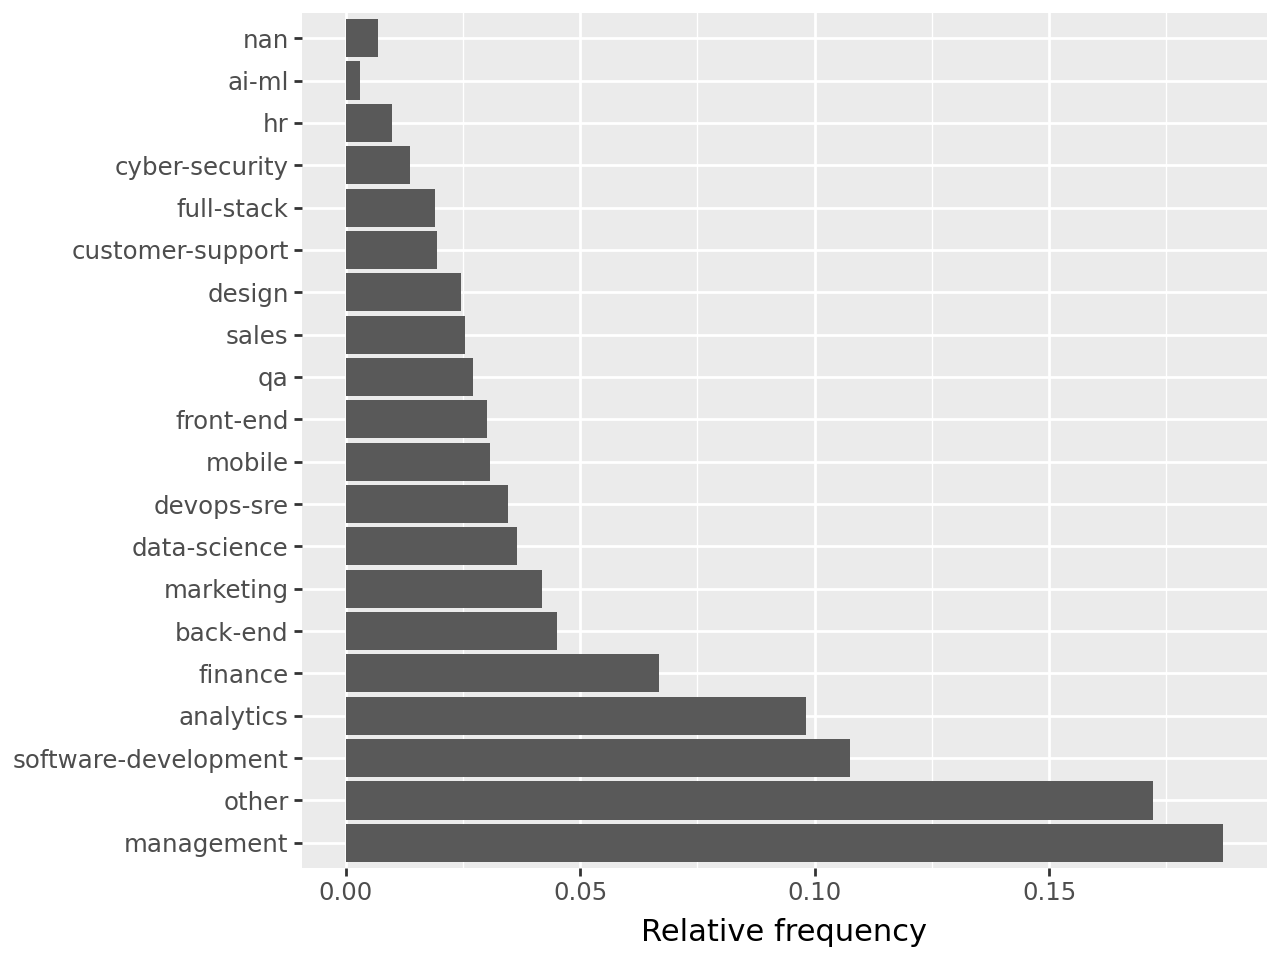

In [8]:
domains_sorted=data['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(data['domain'], categories=domains_sorted)

( p9.ggplot(
    data=data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
)

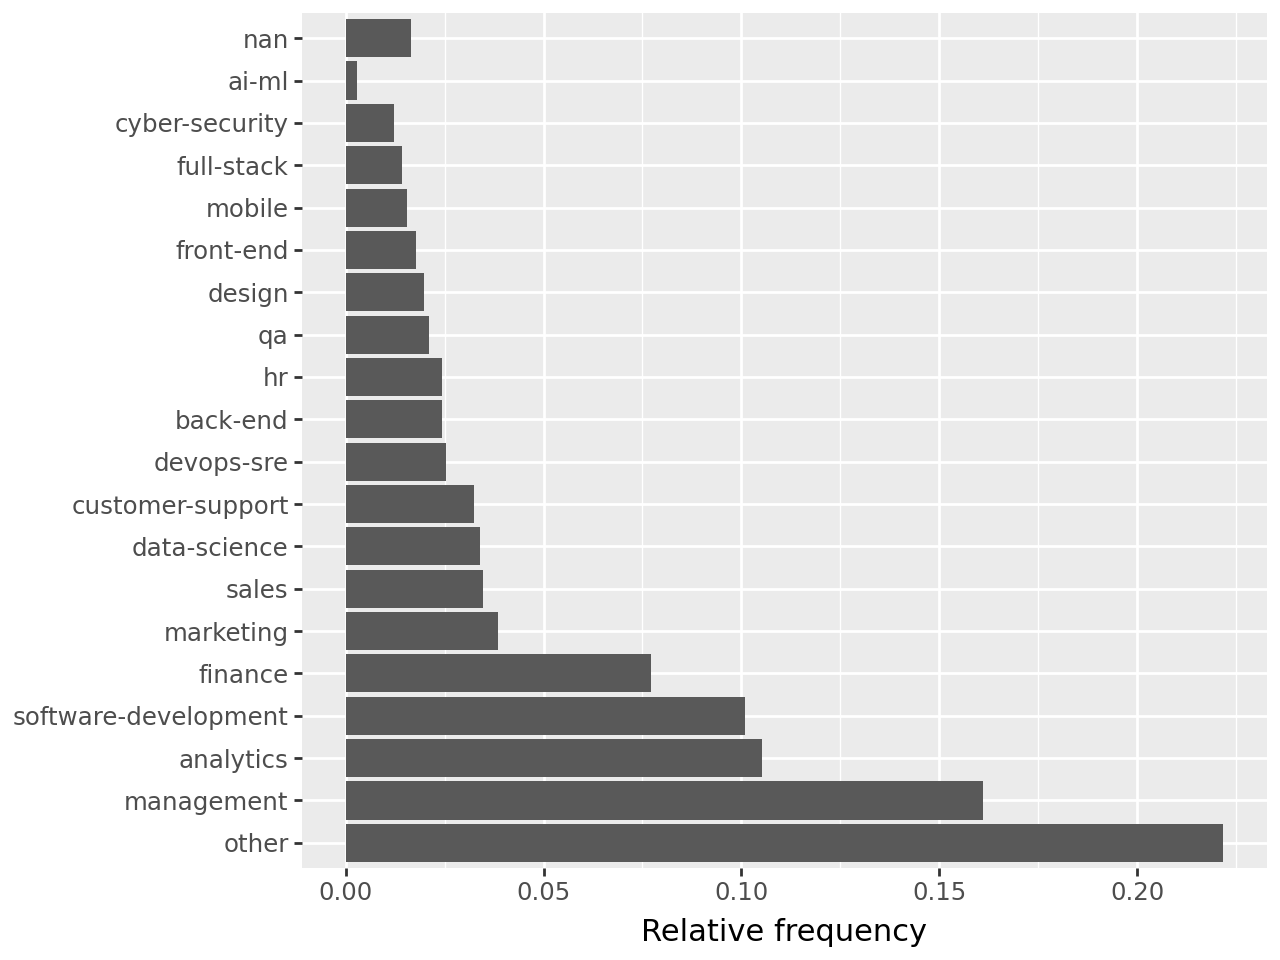

In [15]:

domains_sorted=new_data['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(new_data['domain'], categories=domains_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
)

In [26]:
domain_counts_daily=data.groupby(['date_added','domain'])['domain'].count()
domain_counts_daily=domain_counts_daily.reset_index(name='counts')
domain_counts_daily


,date_added,domain,counts
0,2024-04-02 00:00:00,ai-ml,4
1,2024-04-02 00:00:00,analytics,72
2,2024-04-02 00:00:00,back-end,24
3,2024-04-02 00:00:00,customer-support,10
4,2024-04-02 00:00:00,cyber-security,4
...,...,...,...
4190,2024-11-10 00:00:00,mobile,11
4191,2024-11-10 00:00:00,other,53
4192,2024-11-10 00:00:00,qa,6
4193,2024-11-10 00:00:00,sales,3


In [57]:
domain_counts_daily[domain_counts_daily['counts']==272]

,date_added,domain,counts
4074,2024-11-04 00:00:00,management,272


In [69]:
data[(data['date_added']=='2024-11-04 00:00:00') & (data['domain']=='management')]['job_name']

82656                             Customer Success Manager
82657                                  Engineering Manager
82658                                         Project lead
82659                                            Team lead
82660    Solution Architect/ Tech Lead  in Mobile Team ...
                               ...                        
83685                                     Delivery Manager
83686                                       Technical Lead
83687                     Shift Manager for Live88 Studios
83688                             Service Delivery Manager
83689                              Email Marketing Manager
Name: job_name, Length: 272, dtype: object

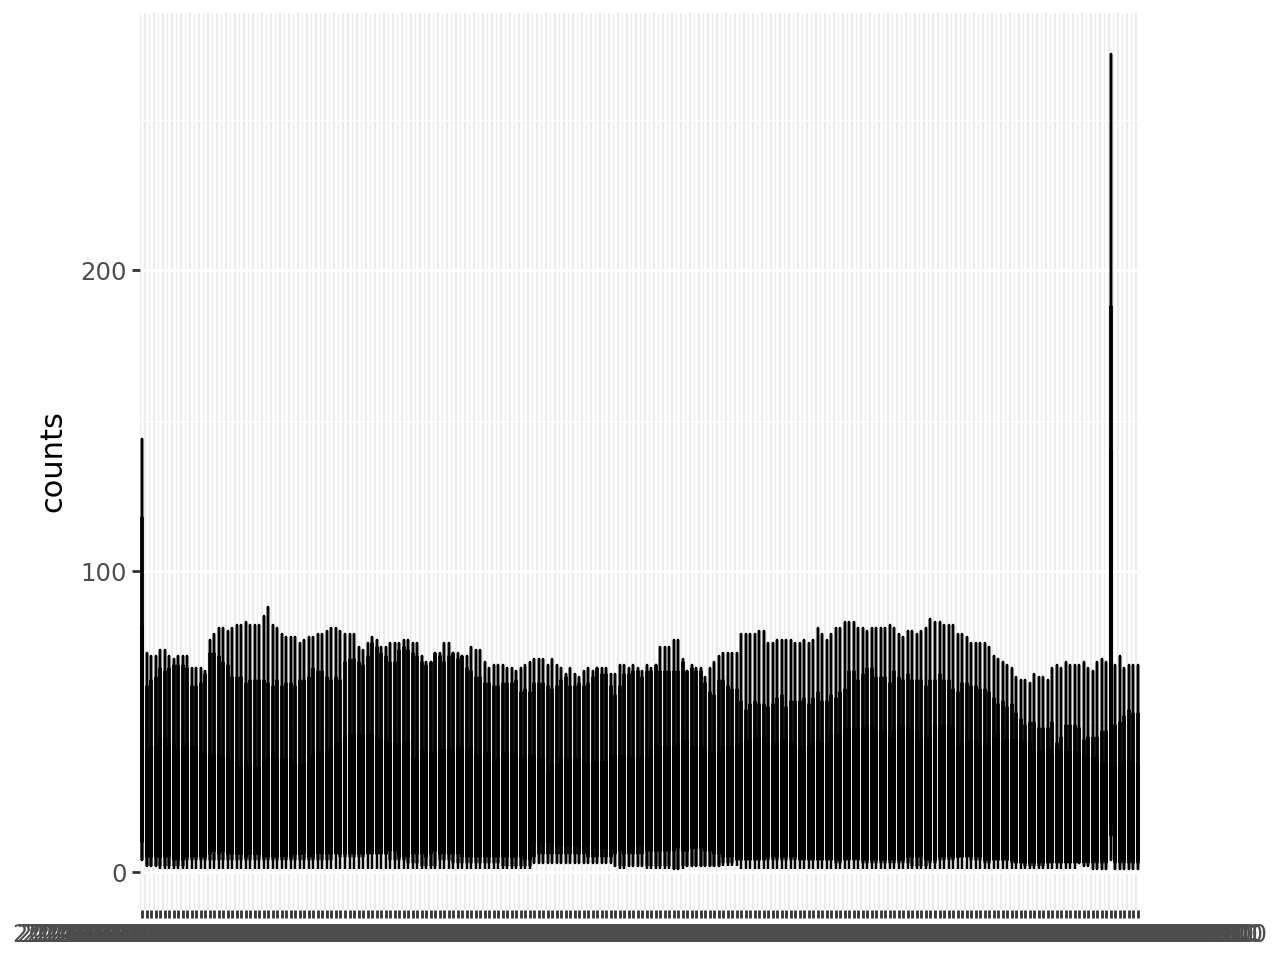

In [60]:
(p9.ggplot(
  data=domain_counts_daily,
  mapping=p9.aes(x='date_added',y='counts'))
+ p9.geom_line()
+ p9.labs(x='')#ticks by date
)

# What tech stacks are the most popular?
Sort by tech stack (if available), report frequency

# Who are the biggest hirerers?

In [16]:
new_data["company_name"].value_counts()

company_name
bolt             422
wise             304
luminor          153
seb              127
yolo group       117
                ... 
mercell            2
change invest      2
jobbatical         2
fortumo            2
boku               1
Name: count, Length: 73, dtype: int64

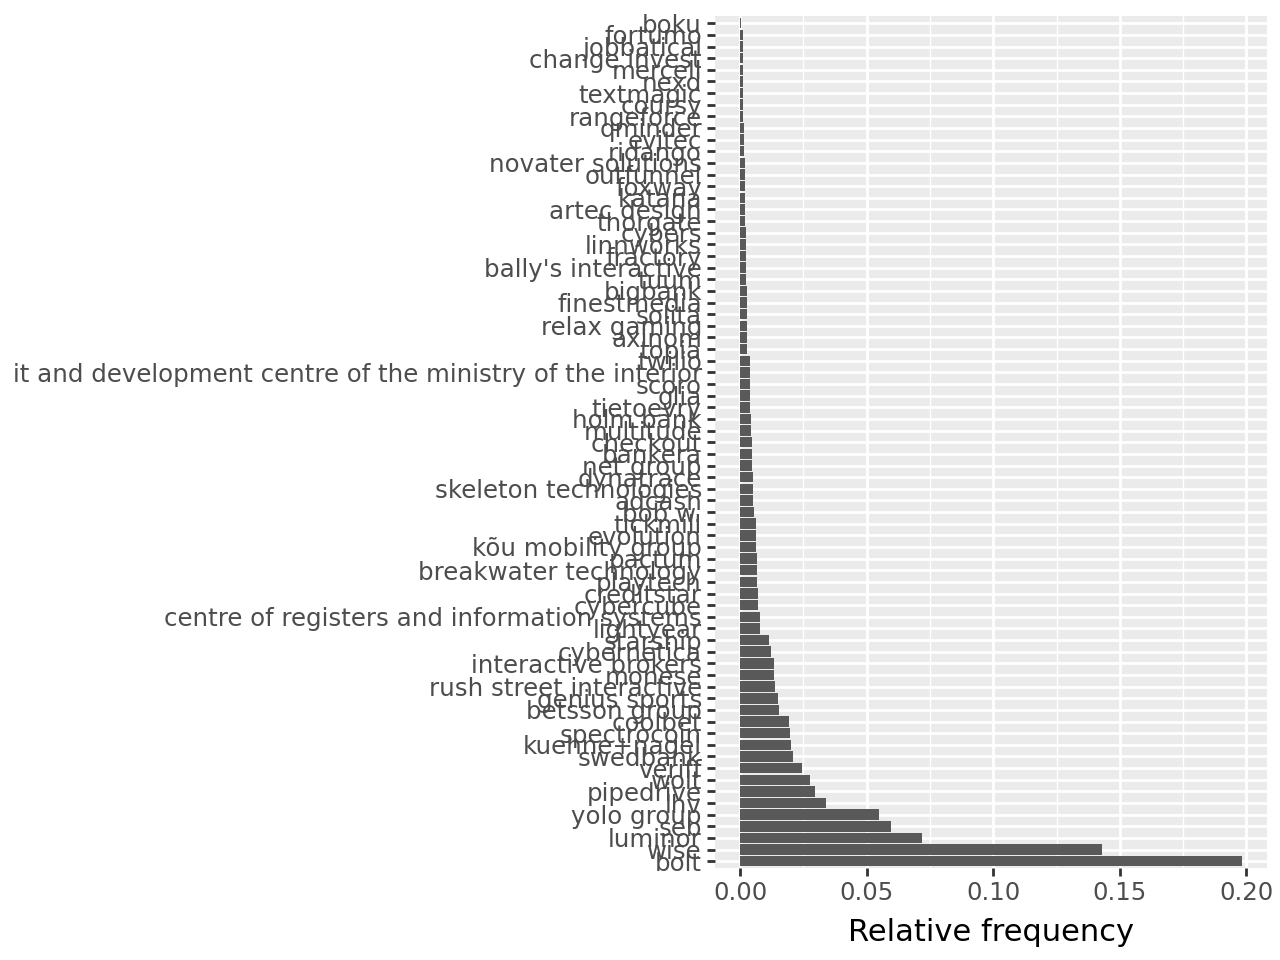

In [17]:
company_name_sorted=new_data['company_name'].value_counts().index.tolist()
domain_cat=pd.Categorical(new_data['company_name'], categories=company_name_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
)